In [1]:
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import GaussianMixture
import time

In [2]:
# Load data from S3
lines = sc.textFile(
    name="s3://csed516/smalldatasetspark/wise-colors-15-20-subsetsmall8.csv",
    minPartitions=24,
)
parts = lines.map(lambda l: l.split(","))
sources = parts.map(lambda p: (float(p[1]), float(p[2]), float(p[3]), float(p[4])))

In [3]:
# Train model
start = time.time()
gmm = GaussianMixture.train(rdd=sources, k=7)
end = time.time()

In [4]:
print("Model trained in {:.2f} minutes, using {} partitions".format(
    (end - start)/60,
    sources.getNumPartitions(),
))

Model trained in 22.03 minutes, using 24 partitions


In [5]:
gmm.save(sc, "gmm.model.2")

In [6]:
color_codes = ["b", "g", "r", "c", "m", "y", "k"]
names_and_ansi_codes = {
    "b": [34, "blue"],
    "g": [32, "green"],
    "r": [31, "red"],
    "c": [36, "cyan"],
    "m": [35, "magenta"],
    "y": [33, "yellow"],
    "k": [30, "black"],
}

def print_class_params(_class):
    print("weight: {:.3f}".format(gmm.weights[_class]))
    print("mean: [{:.3f} {:.3f} {:.3f} {:.3f}]".format(*gmm.gaussians[_class].mu))
    cov = gmm.gaussians[_class].sigma.values
    print("covariance matrix: [{:6.3f} {:6.3f} {:6.3f} {:6.3f}]".format(
        *[cov[i*4] for i in range(4)]
    ))
    print("                   [{:6.3f} {:6.3f} {:6.3f} {:6.3f}]".format(
        *[cov[(i*4)+1] for i in range(4)]
    ))
    print("                   [{:6.3f} {:6.3f} {:6.3f} {:6.3f}]".format(
        *[cov[(i*4)+2] for i in range(4)]
    ))
    print("                   [{:6.3f} {:6.3f} {:6.3f} {:6.3f}]".format(
        *[cov[(i*4)+3] for i in range(4)]
    ))
    print("color: \x1b[{}m{}\x1b[0m".format(*names_and_ansi_codes[color_codes[_class]]))

### Class 0

In [7]:
print_class_params(_class=0)

weight: 0.144
mean: [2.195 3.519 2.503 0.025]
covariance matrix: [ 1.219  1.028 -0.002  0.003]
                   [ 1.028  1.135  0.033 -0.000]
                   [-0.002  0.033  1.483  0.023]
                   [ 0.003 -0.000  0.023  0.021]
color: blue


### Class 1

In [8]:
print_class_params(_class=1)

weight: 0.046
mean: [1.388 3.404 3.864 0.291]
covariance matrix: [ 0.887  0.261  0.455 -0.179]
                   [ 0.261  0.760 -0.193  0.039]
                   [ 0.455 -0.193  0.871 -0.265]
                   [-0.179  0.039 -0.265  0.394]
color: green


### Class 2

In [9]:
print_class_params(_class=2)

weight: 0.189
mean: [1.918 2.579 3.427 0.184]
covariance matrix: [ 0.247  0.161 -0.081 -0.026]
                   [ 0.161  0.203 -0.083 -0.054]
                   [-0.081 -0.083  0.281 -0.010]
                   [-0.026 -0.054 -0.010  0.155]
color: red


### Class 3

In [10]:
print_class_params(_class=3)

weight: 0.183
mean: [0.802 1.756 3.499 0.269]
covariance matrix: [ 0.070  0.068 -0.013 -0.016]
                   [ 0.068  0.207 -0.042 -0.052]
                   [-0.013 -0.042  0.225  0.001]
                   [-0.016 -0.052  0.001  0.213]
color: cyan


### Class 4

In [11]:
print_class_params(_class=4)

weight: 0.018
mean: [2.152 5.449 1.045 0.057]
covariance matrix: [ 8.538 -0.041  0.652  0.092]
                   [-0.041  5.274  0.454 -0.024]
                   [ 0.652  0.454  2.014  0.005]
                   [ 0.092 -0.024  0.005  0.085]
color: magenta


### Class 5

In [12]:
print_class_params(_class=5)

weight: 0.198
mean: [0.808 1.628 2.268 -0.070]
covariance matrix: [ 0.059  0.059 -0.021 -0.001]
                   [ 0.059  0.079 -0.023  0.001]
                   [-0.021 -0.023  0.653 -0.015]
                   [-0.001  0.001 -0.015  0.015]
color: yellow


### Class 6

In [13]:
print_class_params(_class=6)

weight: 0.221
mean: [2.163 2.670 2.072 0.015]
covariance matrix: [ 0.278  0.206 -0.046  0.044]
                   [ 0.206  0.170 -0.041  0.033]
                   [-0.046 -0.041  0.899 -0.024]
                   [ 0.044  0.033 -0.024  0.019]
color: black


In [14]:
classes = gmm.predict(sources)
colors = classes.map(lambda c: color_codes[c])

x = sources.map(lambda s: s[0])
y = sources.map(lambda s: s[1])
z = sources.map(lambda s: s[2])
w = sources.map(lambda s: s[3])

In [15]:
def plot_2d_scatterplot(x_axis, y_axis):
    figure = plt.figure(figsize=(16,12))
    plt.xlabel(x_axis, fontsize="xx-large")
    plt.ylabel(y_axis, fontsize="xx-large")
    plt.scatter(eval(x_axis).collect(), eval(y_axis).collect(), s=0.125, c=colors.collect())
    plt.show()

### x vs. y

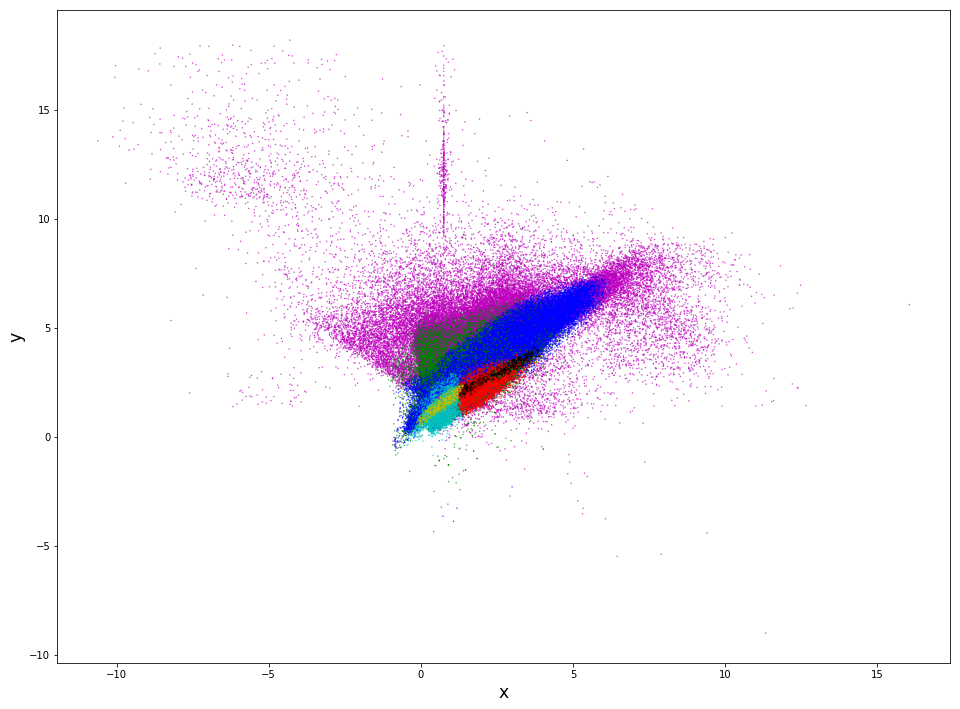

In [16]:
plot_2d_scatterplot(x_axis="x", y_axis="y")

### x vs. z

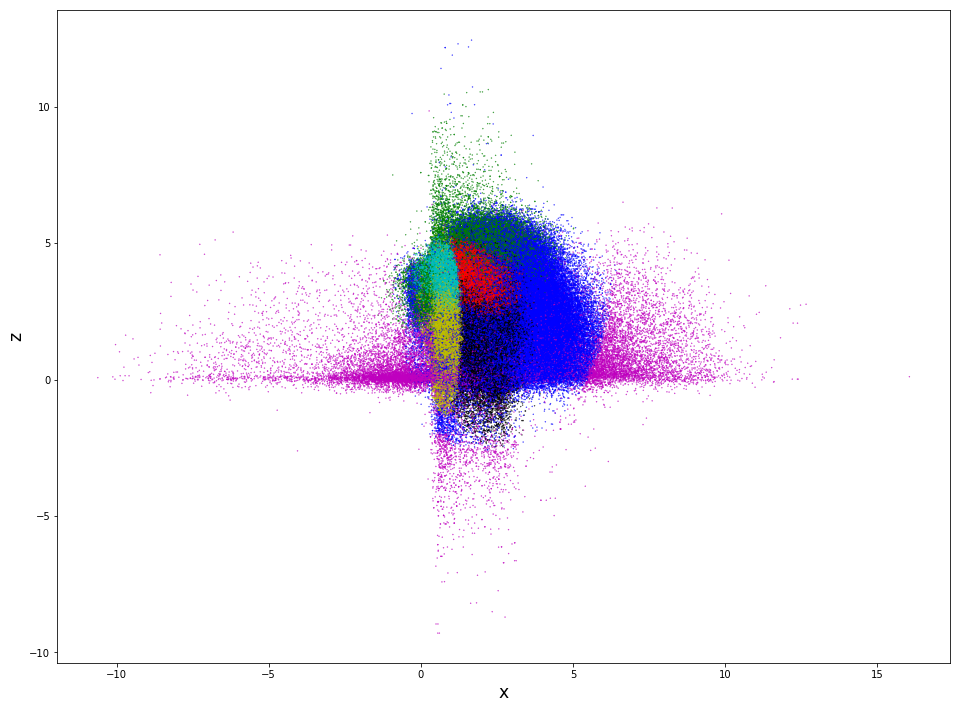

In [17]:
plot_2d_scatterplot(x_axis="x", y_axis="z")

### x vs. w

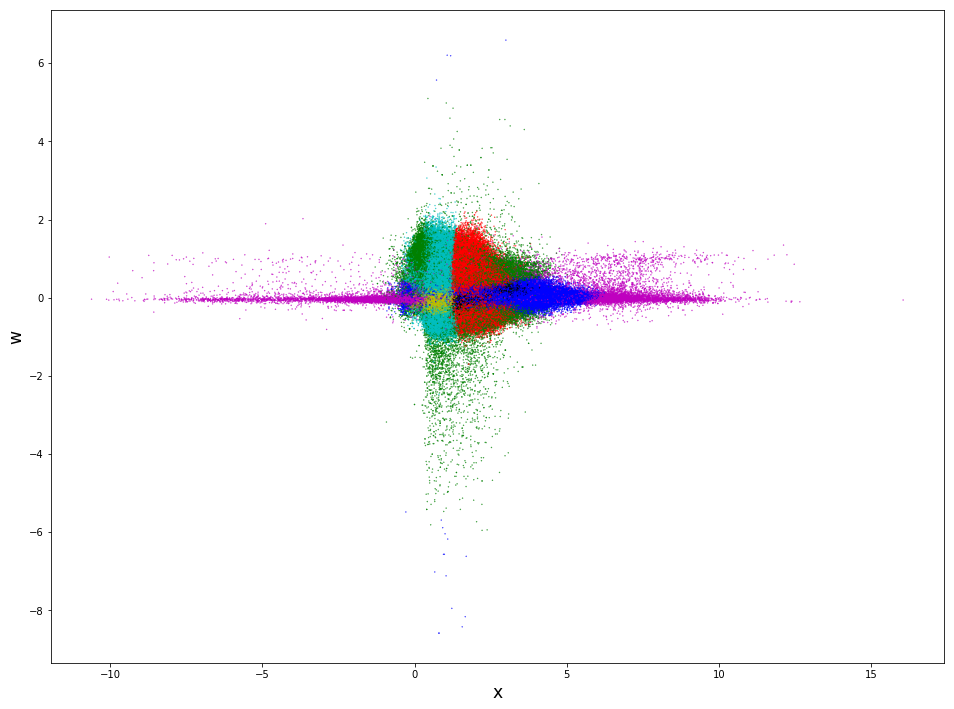

In [18]:
plot_2d_scatterplot(x_axis="x", y_axis="w")

### y vs. z

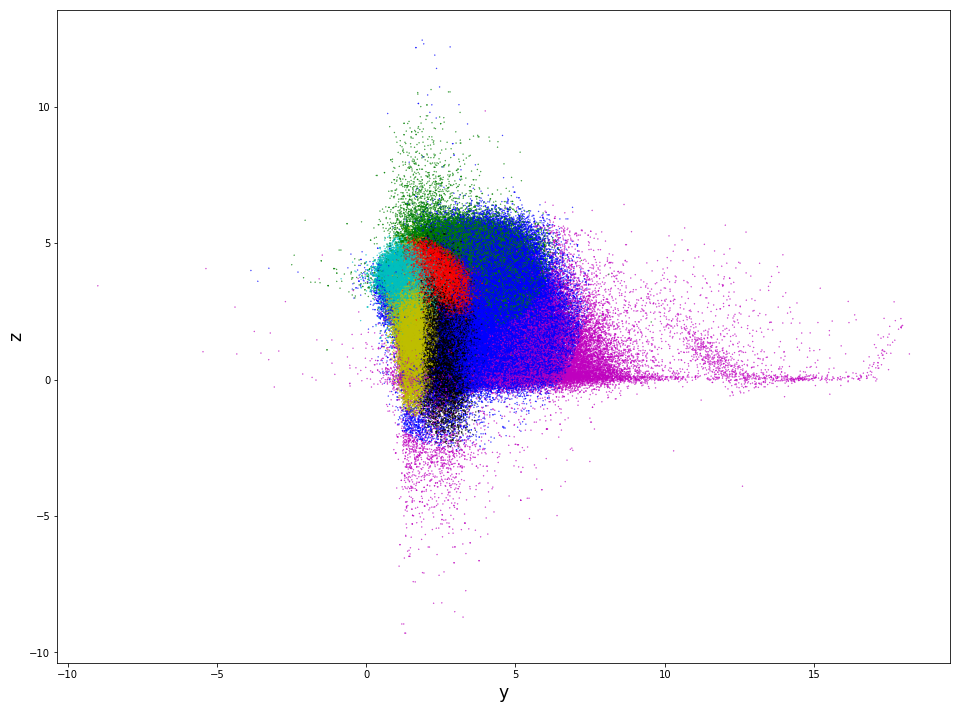

In [19]:
plot_2d_scatterplot(x_axis="y", y_axis="z")

### y vs. w

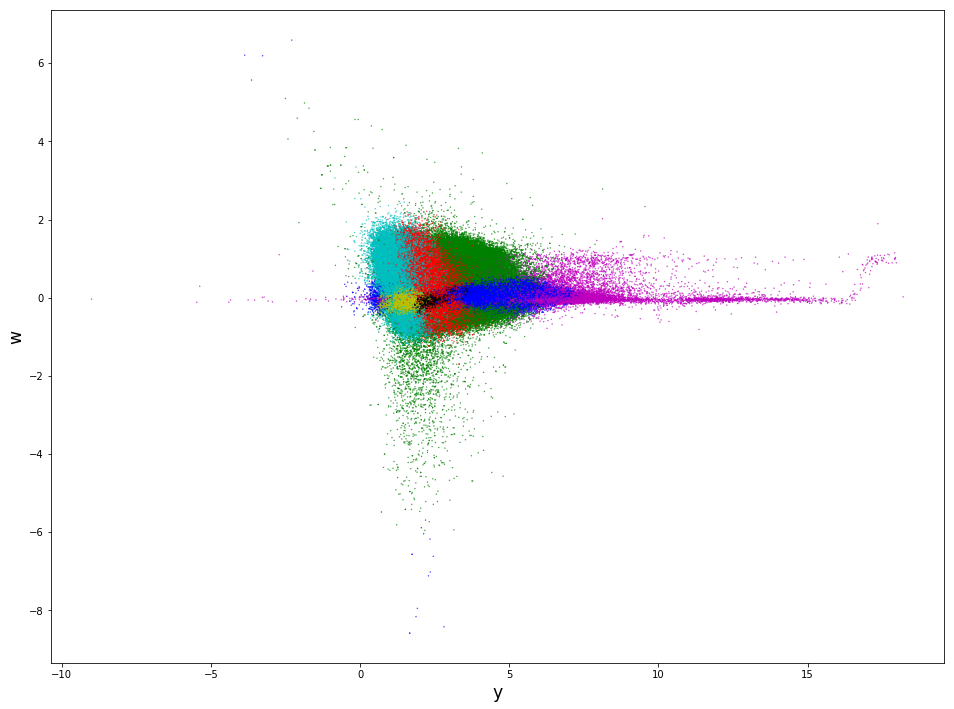

In [20]:
plot_2d_scatterplot(x_axis="y", y_axis="w")

### z vs. w

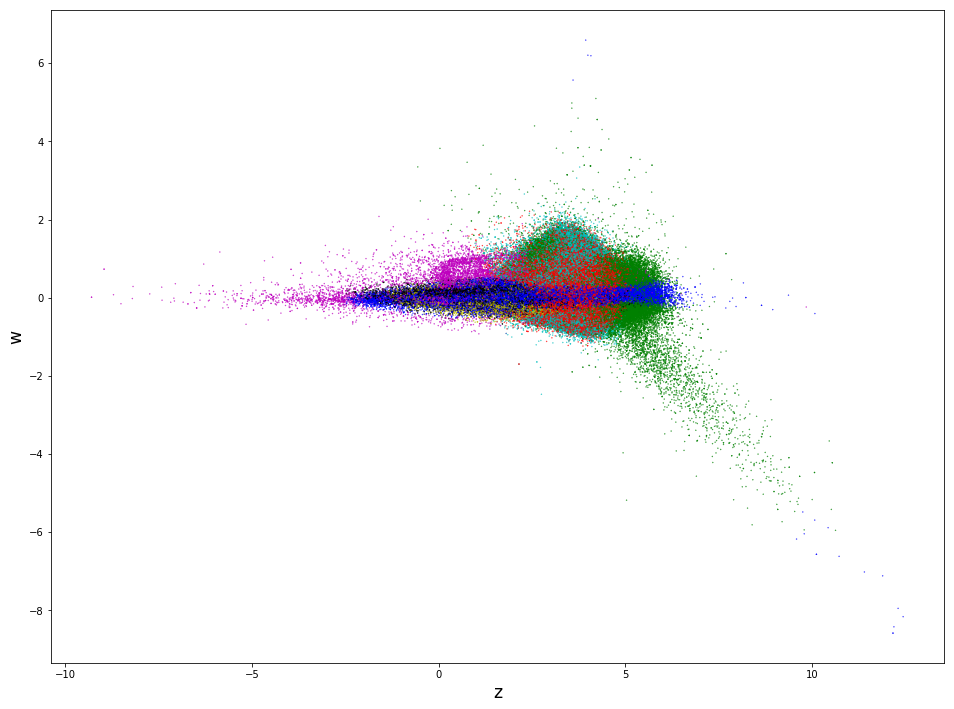

In [21]:
plot_2d_scatterplot(x_axis="z", y_axis="w")